This notebook shows code for Python version of the R code for multivariate Gaussian quadrature described in the article below:

https://www.r-bloggers.com/2015/09/notes-on-multivariate-gaussian-quadrature-with-r-code/

In [1]:
import numpy as np
import scipy
import warnings
import itertools
import matplotlib.pyplot as plt
plt.ion()

In [2]:
def hermite(points, z):
    p1 = 1/np.pi**0.4
    p2 = 0
    for i in range(1, points+1):
        p3 = p2
        p2 = p1
        p1 = z * np.sqrt(2/i) * p2 - np.sqrt((i - 1)/i) * p3
        #print(p1)
    pp = np.sqrt(2 * points) * p2
    return np.array([p1, pp])

In [3]:
%timeit hermite(10, 0.6)

19.2 µs ± 989 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [4]:
hermite(5, 0.6) # checked against R

array([ 0.40761999, -0.32733477])

In [5]:
def gauss_hermite(points, interlim=50):
    x = np.zeros(points)
    w = np.zeros(points)
    m = np.int(np.floor((points + 1)/2))
    for i in range(1, m+1):
        if i == 1:
            z = np.sqrt(2 * points +1) - 2 * (2 * points + 1)**(-1/6)
        elif i == 2:
            z = z - np.sqrt(points)/z
        elif (i == 3 or i == 4):
            z = 1.9 * z - 0.9 *x[i-1-2]
        else:
            z = 2 * z - x[i-1-2]
        # Newton-Raphson loop 
        for j in range(interlim):
            z1 = z
            p = hermite(points, z)
            z = z1 - p[0]/p[1]
            if np.abs(z1 - z)<1e-15:
                break
        if j == interlim - 1:
            warnings.warn("iteration limit reached!")
        x[i-1] = z
        x[points - i] = -z
        f = 2/p[1]**2
        w[i-1] = f
        w[points - i] = f
    return x * np.sqrt(2), w/np.sum(w)

In [6]:
%timeit gauss_hermite(5)

180 µs ± 4.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
gauss_hermite(5) # checked against R

(array([ 2.85697001e+00,  1.35562618e+00,  2.65984009e-37, -1.35562618e+00,
        -2.85697001e+00]),
 array([0.01125741, 0.22207592, 0.53333333, 0.22207592, 0.01125741]))

In [8]:
def mGauss_hermite(n, mu, sigma, prune=None):
    dm = len(mu)
    gh = gauss_hermite(n)
    l1 = [gh[0]]*dm
    l2 = [gh[1]]*dm
    x = np.array(np.meshgrid(*l1)).transpose().reshape((-1, dm))
    w = np.prod(np.array(np.meshgrid(*l2)).transpose().reshape(-1,dm),
                    axis=1)
    if prune is not None:
        qwt = np.quantile(w, prune)
        inds = np.where(w>qwt)[0]
        x = x[inds]
        w = w[inds]
    eigval, eigvec = np.linalg.eig(sigma)
    rot = np.dot(eigvec, np.diag(np.sqrt(eigval)))
    x = np.dot(rot,x.transpose()).transpose()
    return x+mu, w

In [9]:
mean = np.zeros(2)
cov = np.ones((2,2))
cov[0,1] = 0.5
cov[1,0] = 0.5
prune = 0.2
n = 10

In [10]:
x, w = mGauss_hermite(n, mean, cov, prune)
print(x.shape, w.shape)

(80, 2) (80,)


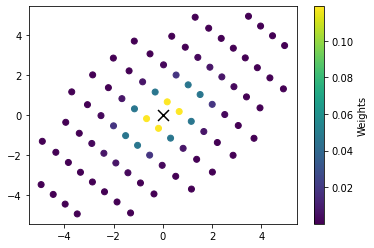

In [11]:
plt.scatter(x[:,0], x[:,1], c=w)
cbar = plt.colorbar()
plt.scatter(mean[0], mean[1], color="black", marker="x", s=120)
cbar.set_label("Weights")

In [12]:
%timeit mGauss_hermite(10, mean, cov, prune)

666 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
mean = np.zeros(3)
cov = np.diag(np.ones(3))
prune = 0.2
n = 10

In [14]:
x, w = mGauss_hermite(n, mean, cov, prune)
print(x.shape, w.shape)

(768, 3) (768,)


In [15]:
# uncomment to view the 3D diagram
"""
import plotly.graph_objects as go
import numpy as np

a, b, c = x.transpose()

fig = go.Figure(data=[go.Scatter3d(
    x=a,
    y=b,
    z=c,
    mode='markers',
    marker=dict(
        size=5,
        color=w,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.75
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show() 
"""

"\nimport plotly.graph_objects as go\nimport numpy as np\n\na, b, c = x.transpose()\n\nfig = go.Figure(data=[go.Scatter3d(\n    x=a,\n    y=b,\n    z=c,\n    mode='markers',\n    marker=dict(\n        size=5,\n        color=w,                # set color to an array/list of desired values\n        colorscale='Viridis',   # choose a colorscale\n        opacity=0.75\n    )\n)])\n\n# tight layout\nfig.update_layout(margin=dict(l=0, r=0, b=0, t=0))\nfig.show() \n"